## Example

...

In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
plt.style.use('ggplot')
path_data = 'data' + os.sep

### Import rupture information

For now we include two options to specify the rupture: 

1) **ShakeMap rupture** json file provided with latest USGS shakemap version: 
https://earthquake.usgs.gov/earthquakes/eventpage/us6000jllz/shakemap/metadata  
The `rupture.json` file was downloaded on 2023-14-02 at 14:55 CET. Check for new updates before applying.

2) **Finite fault** provided from USGS: 
https://earthquake.usgs.gov/earthquakes/eventpage/us6000jllz/finite-fault 

We model the rupture as a collection of multiple planar rupture surfaces. This is done via the `get_planarsurface` method. For significant changes in the rupture information and geometry, one might has to adapt this method. 

In the following examples we'll use option 1.

In [2]:
from openquake.hazardlib.source.rupture import BaseRupture
from openquake.hazardlib.geo.point import Point
from utils import get_planarsurface

option_rupture = 1 # 1 or 2 as stated above

f = open(path_data + 'rupture.json')
rup_temp = json.load(f)
f.close()

print('Used rupture model:')
print(rup_temp['metadata']['reference'])

if option_rupture == 1:
    rupture_surface = get_planarsurface(rup_temp['features'][0]['geometry'])
elif option_rupture == 2:
    from utils import get_finite_fault
    rupture_surface = get_planarsurface(get_finite_fault())
rup_temp = rup_temp['metadata']
rupture = BaseRupture(mag = rup_temp['mag'], rake = rup_temp['rake'], 
                    tectonic_region_type = 'Active Shallow Crust', 
                    hypocenter = Point(longitude = rup_temp['lon'], 
                                        latitude = rup_temp['lat'],
                                        depth = rup_temp['depth']),
                    surface = rupture_surface)

Used rupture model:
Source: Wald Finite Fault Model (surface trace, FF model, known faults)Event ID: us6000jllzModel created: 2023-02-09 19:17 MST


### Import station list

For now we include the station list provided by the USGS shakemap system.
https://earthquake.usgs.gov/earthquakes/eventpage/us6000jllz/shakemap/metadata  
The `stationlist.json` file was downloaded on 2023-14-02 at 14:55 CET. Check for new updates before applying.

The method `read_stationlist` collects the longitude, latitude and vs30 values for each station, as well as the recorded amplitude values in two horizontal directions. Following amplitudes are available: 'PGA', 'PGV', 'SA(0.3)', 'SA(1.0)', 'SA(3.0)'. For PGV the unit is cm/s, while all accelerations are in units of g (not %g !).

In [3]:
from utils import read_stationlist

f = open(path_data + 'stationlist.json')
stations_temp = json.load(f)
stations_temp = stations_temp['features']
f.close()

dfstations = read_stationlist(stations_temp)
dfstations

,id,code,longitude,latitude,vs30,sa(0.3)_E,sa(1.0)_E,sa(3.0)_E,pga_E,pgv_E,sa(0.3)_N,sa(1.0)_N,sa(3.0)_N,pga_N,pgv_N
0,KO.ARPRA,ARPRA,38.3356,39.0929,878.13,0.115508,0.060479,0.049121,0.044765,12.7289,0.086159,0.102017,0.044014,0.050168,10.1561
1,KO.CMRD,CMRD,34.9902,37.6623,762.04,0.014220,0.008482,0.004580,0.004960,2.6909,0.018498,0.013853,0.007351,0.007499,3.5835
2,KO.KHMN,KHMN,37.1574,37.3916,313.91,0.706746,0.601586,0.331964,0.530371,100.0960,0.630066,0.486919,0.232605,0.629572,80.9896
3,KO.KOZK,KOZK,34.8680,39.2101,543.84,0.014698,0.029326,0.011246,0.010661,4.7466,0.013072,0.031914,0.010040,0.010260,5.2272
4,KO.KRTS,KRTS,35.3750,36.5730,331.46,0.173221,0.079116,0.034312,0.042816,15.1153,0.166746,0.051626,0.024567,0.055023,12.5387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,KO.ERBG,ERBG,36.6768,40.7120,900.00,0.003421,0.008361,0.006608,0.003214,1.5119,0.004366,0.012170,0.006565,0.004122,1.1194
256,KO.GUMT,GUMT,39.4780,40.4665,900.00,0.003795,0.004971,0.004307,0.002550,1.1218,0.003197,0.004348,0.002680,0.002145,0.8801
257,KO.KRMN,KRMN,33.2636,37.1740,381.95,0.010515,0.014647,0.003190,0.005408,1.1971,0.009231,0.014977,0.006356,0.006946,1.2500
258,KO.KYHL,KYHL,37.8955,40.3244,826.26,0.009267,0.022780,0.008636,0.007456,1.9005,0.009624,0.009802,0.005788,0.005208,1.3886


Dimensions of shown map in km:
1000.0 x 758.0


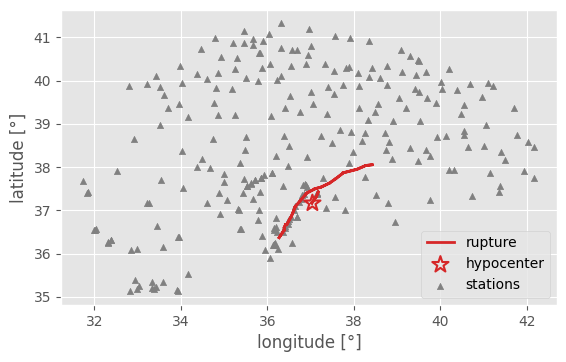

In [4]:
from utils import get_extent_size
fig, ax = plt.subplots()
for i, surf in enumerate(rupture_surface.surfaces):
    if i == 0: label = 'rupture'
    else: label = None
    lons, lats = surf.get_surface_boundaries()
    ax.plot(lons, lats, color='tab:red', lw=2,zorder=2, label=label)
    # ax.plot(surf.mesh.lons, surf.mesh.lats, color='tab:red', lw=2,zorder=2, label=label)
ax.scatter(rupture.hypocenter.longitude, rupture.hypocenter.latitude, marker='*', color='none', 
           edgecolor='tab:red', s=150, zorder=2, label='hypocenter', lw=1.5)
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=20, color='gray', alpha=1, zorder=1,label='stations')
ax.set_aspect('equal')
ax.set_xlabel('longitude [°]')
ax.set_ylabel('latitude [°]')
ax.legend()
extent = get_extent_size(ax)
print('Dimensions of shown map in km:')
print(str(extent[0]) + ' x ' + str(extent[1]))

### Initialize modules

In the following we specify the different modules required to compute the shakemap. 
1. The ground-motion model: I use a small wrapper `GMM` around the openquake implementation of the GMM. We tested the method with the two GMMs (`AkkarEtAlRjb2014` and `CauzziEtAl2014`) which together account for 70% of the logic-tree weights in the USGS shakemap system. Both of these GMMs are defined for the average horizontal value (e.g., the geometric mean of the recorded amplitudes at two horizontal directions). 
2. The spatial-correlation model: Here I use three different models. The model `EspositoIervolino2012esm` was derived from European ground-motion data. The model `HeresiMiranda2019` was derived for a worldwide dataset and has a slightly different functional form. The recently published model of `BodenmannEtAl2022` was also estimated from a worldwide dataset, but accounts for soil and path effects (in addition to spatial proximity). Amongst the three models `EspositoIervolino2012esm` assigns strongest correlations for close sites.
3. Finally, I use a small wrapper `Stations` which takes information from the dataframe shown above. 

References to the original papers can be found in the corresponding documentations.

In [5]:
from modules.shakemap import Stations, GMM
from modules.spatialcorrelation import (HeresiMiranda2019, 
                                        EspositoIervolino2012esm,
                                        BodenmannEtAl2022)
from openquake.hazardlib.gsim.akkar_2014 import AkkarEtAlRjb2014
from openquake.hazardlib.gsim.cauzzi_2014 import CauzziEtAl2014

# Specify considered intensity measure: 'PGA', 'SA(0.3)', 'SA(1.0)', 'SA(3.0)'
im_string = 'SA(1.0)'

# Specify Ground-Motion model
gmm = GMM(CauzziEtAl2014(), im_string)
# gmm = GMM(AkkarEtAlRjb2014(), im_string)

# Specify Correlation model
scm = EspositoIervolino2012esm(im_string)
# scm = HeresiMiranda2019(im_string)
# scm = BodenmannEtAl2022(im_string, rupture)

# Wrap stations
stations = Stations(dfstations, ['longitude', 'latitude', 'vs30'], im_string)

Assemble the defined modules and initialize a `Shakemap` object. This object contains all methods to perform the computations and the sampling. See also the (evolving) documentation in `modules/shakemap.py`. 

In [6]:
from modules.shakemap import Shakemap
shakemap = Shakemap(Rupture = rupture, 
                    Stations = stations,
                    GMM = gmm,
                    SpatialCorrelationModel = scm)

### Example 1: Maps of marginal parameters

In this first example, we'll look at a region of size 37 x 35 km. The region is located in the Turkish province of Hatay, which is at the south-western end of the rupture (shown with the black sqaure below).

We first load the csv file which contains vs30 values at a longitude-latitude grid in this region. Then we initialize the `Sites` object, which creates an `openquake` mesh (similar to the Stations object above).

In [7]:
dfsites = pd.read_csv(path_data + 'grid_example.csv')
print('Number of grid points: ' + str(len(dfsites)))

from modules.shakemap import Sites
sites = Sites(dfsites, ['longitude', 'latitude', 'vs30'])

Number of grid points: 30042


Dimensions of shown map in km:
178.0 x 278.0


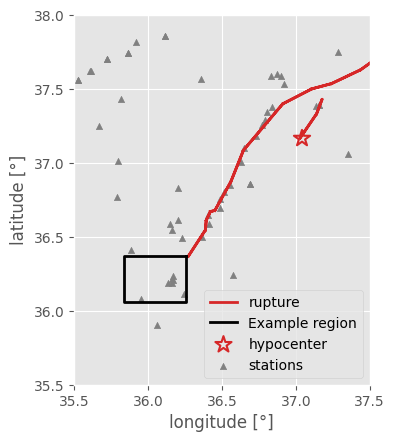

In [8]:
fig, ax = plt.subplots()
for i, surf in enumerate(rupture_surface.surfaces):
    if i == 0: label = 'rupture'
    else: label = None
    lons, lats = surf.get_surface_boundaries()
    ax.plot(lons, lats, color='tab:red', lw=2,zorder=2, label=label)
ax.scatter(rupture.hypocenter.longitude, rupture.hypocenter.latitude, marker='*', color='none', 
           edgecolor='tab:red', s=150, zorder=2, label='hypocenter', lw=1.5)
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=20, color='gray', alpha=1, zorder=1,label='stations')
lons_bbox, lats_bbox = sites.get_bbox()
ax.plot(lons_bbox, lats_bbox, color='black', lw=2, label='Example region')
ax.set_xlim([35.5, 37.5]); ax.set_ylim([35.5, 38]); ax.set_aspect('equal')
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
ax.legend()
extent = get_extent_size(ax)
print('Dimensions of shown map in km:')
print(str(extent[0]) + ' x ' + str(extent[1]))

**Overview and soil conditions**

The figure below plots the vs30 values in the considered region. Those values are taken from USGS (https://earthquake.usgs.gov/data/vs30/).

The black square shows the region that will be examined in Example 2. Gray triangles indicate seismic stations.

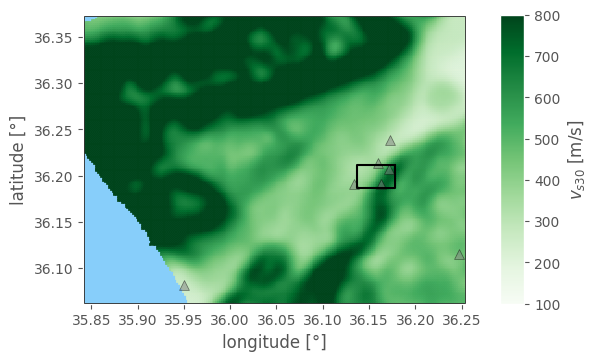

Dimensions of shown map in km:
37.0 x 35.0


In [9]:
# Add bbox for example 2
lons_bbox2 = np.array([36.17847587, 36.17847587, 36.13702504, 36.13702504, 36.17847587])
lats_bbox2 = np.array([36.21199931, 36.18703261, 36.18703261, 36.21199931, 36.21199931])

fig, ax = plt.subplots(figsize=(6,3.5), sharey=True, constrained_layout=True)
for surf in rupture_surface.surfaces:
    lons, lats = surf.get_surface_boundaries()
    ax.plot(lons, lats, color='tab:red', lw=2, zorder=2)
im = ax.scatter(dfsites.longitude, dfsites.latitude, c=dfsites.vs30.values, 
                vmin=100, vmax=800, cmap=plt.get_cmap('Greens'), s=2, marker='s')
ax.set_aspect('equal');  ax.grid(False)
lons_bbox, lats_bbox = sites.get_bbox()
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=50, color='gray', alpha=0.5, edgecolor='black')
ax.plot(lons_bbox, lats_bbox, color='black', lw=2)
ax.plot(lons_bbox2, lats_bbox2, color='black', lw=1.5, ls='-', label = 'Example 2')
ax.set_xlim([lons_bbox.min(), lons_bbox.max()]); ax.set_ylim([lats_bbox.min(), lats_bbox.max()])
plt.colorbar(im, label='$v_{s30}$ [m/s]')
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
ax.set_facecolor('lightskyblue')
plt.show()
extent = get_extent_size(ax)
print('Dimensions of shown map in km:')
print(str(extent[0]) + ' x ' + str(extent[1]))

#### Compute marginal shakemap parameters

We use the `predict_logIM` function to compute the mean and variance of logarithmic im values for the `Sites`. For input `conditional = True` it computes the parameters conditional on the recorded amplitudes, otherwise it computes the mean and variance of the GMM. For input `full_cov = False`, it computes only the diagonal of the covariance matrix, otherwise it computes the full covariance matrix.

Note that we consider more than 30'000 sites in this example, and with a full computation of the covariance matrix we would most probably run into memory issues. The full computation and sampling procedure is shown in Example 2 for a smaller number of sites.

In [10]:
mu, var = shakemap.predict_logIM(sites, conditional=True, full_cov=False)

Map of median intensity measure value conditional on all recorded amplitudes.

Dimensions of shown map in km:
37.0 x 35.0


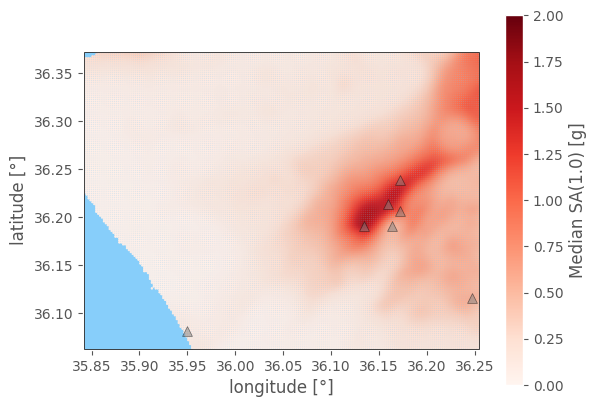

In [11]:
msize = 1.5
fig, ax = plt.subplots()
im = ax.scatter(dfsites.longitude, dfsites.latitude, c=np.exp(mu), vmin=0, vmax=2, s=msize, cmap=plt.get_cmap('Reds'))
ax.set_aspect('equal')
for surf in rupture_surface.surfaces:
    lons, lats = surf.get_surface_boundaries()
    ax.plot(lons, lats, color='black', lw=2,zorder=2, label=label)
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=50, color='gray', alpha=0.5, edgecolor='black')
lons_bbox, lats_bbox = sites.get_bbox()
ax.plot(lons_bbox, lats_bbox, color='black', lw=2)
ax.set_xlim([lons_bbox.min(), lons_bbox.max()]); ax.set_ylim([lats_bbox.min(), lats_bbox.max()])
ax.grid(False)
plt.colorbar(im, label='Median ' + im_string + ' [g]')
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
ax.set_facecolor('lightskyblue')
extent = get_extent_size(ax)
print('Dimensions of shown map in km:')
print(str(extent[0]) + ' x ' + str(extent[1]))

Map of logarithmic standard deviation conditional on all recorded amplitudes.

Dimensions of shown map in km:
37.0 x 35.0


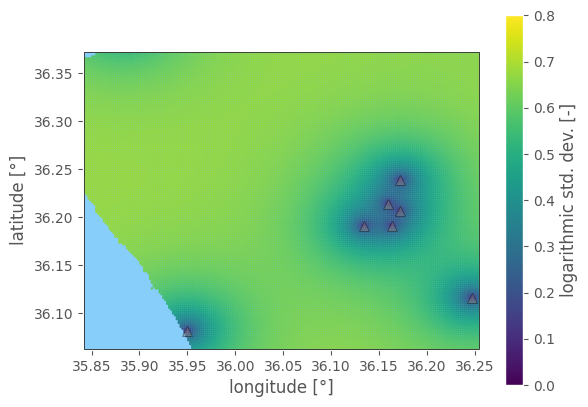

In [12]:
fig, ax = plt.subplots()
im = ax.scatter(dfsites.longitude, dfsites.latitude, c=np.sqrt(var), vmin=0, vmax=0.8, s=msize, cmap=plt.get_cmap('viridis'))
ax.set_aspect('equal')
for surf in rupture_surface.surfaces:
    lons, lats = surf.get_surface_boundaries()
    ax.plot(lons, lats, color='black', lw=2,zorder=2, label=label)
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=50, color='gray', alpha=0.5, edgecolor='black')
lons_bbox, lats_bbox = sites.get_bbox()
ax.plot(lons_bbox, lats_bbox, color='black', lw=2)
ax.set_xlim([lons_bbox.min(), lons_bbox.max()]); ax.set_ylim([lats_bbox.min(), lats_bbox.max()])
ax.grid(False)
plt.colorbar(im, label='logarithmic std. dev. [-]')
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
ax.set_facecolor('lightskyblue')
extent = get_extent_size(ax)
print('Dimensions of shown map in km:')
print(str(extent[0]) + ' x ' + str(extent[1]))

### Example 2: Simulate correlated ground-motion amplitudes conditional on recordings

The csv file `buildings_example.csv` contains the location of more than 14000 buildings in the city of Antakya, Turkey (small black dots in the figure below). The buildings are distributed over an area of only 4 x 3 km.

The building data was derived from a worldwide building footprint dataset offered by Microsoft (https://github.com/microsoft/GlobalMLBuildingFootprints).

For this illustration we randomly sample 2000 buildings from this dataset (orange dots in the figure below).

In [13]:
del mu, var # gain memory

dfsites = pd.read_csv(path_data + 'buildings_example.csv')
sites = Sites(dfsites, ['longitude', 'latitude', 'vs30'])
lons_bbox, lats_bbox = sites.get_bbox()
dfsites_sim = dfsites.sample(n=2000, random_state=91)
sites = Sites(dfsites_sim, ['longitude', 'latitude', 'vs30'])

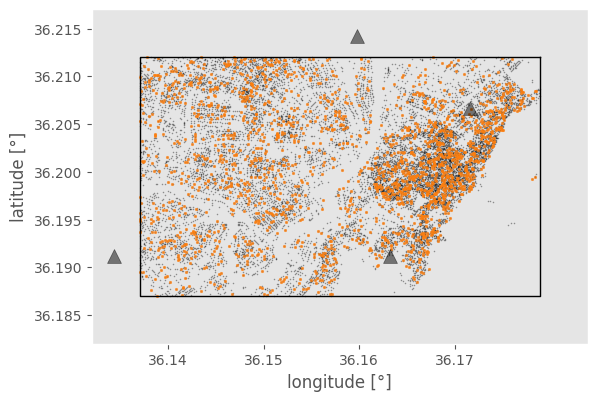

Dimensions of shown map in km:
5.0 x 4.0


In [25]:
fig, ax = plt.subplots()
im = ax.scatter(dfsites.longitude, dfsites.latitude, color='black', s=0.5, alpha=0.25)
im = ax.scatter(dfsites_sim.longitude, dfsites_sim.latitude, color='tab:orange', s=3, alpha=0.75)
ax.set_aspect('equal')
for surf in rupture_surface.surfaces:
    lons, lats = surf.get_surface_boundaries()
    ax.plot(lons, lats, color='black', lw=2,zorder=2, label=label)
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=100, color='black', alpha=0.5, edgecolor='black')
ax.plot(lons_bbox, lats_bbox, color='black', lw=1)
ax.set_xlim([lons_bbox.min()-0.005, lons_bbox.max()+0.005]); ax.set_ylim([lats_bbox.min()-0.005, lats_bbox.max()+0.005])
ax.grid(False)
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
ax.set_xticks(np.arange(36.140, 36.180, 0.01))
plt.show()
extent = get_extent_size(ax)
print('Dimensions of shown map in km:')
print(str(extent[0]) + ' x ' + str(extent[1]))

**Visual comparison of two simulated fields**

The function `sample_logIM` is used to generate spatially correlated fields of logarithmic IM values. If `conditional=True`, samples are generated from the conditional multivariate normal distribution that accounts for recorded amplitudes.

In [15]:
sim_logim2 = shakemap.sample_logIM(sites, nsamples=2, conditional=True, seed=20)

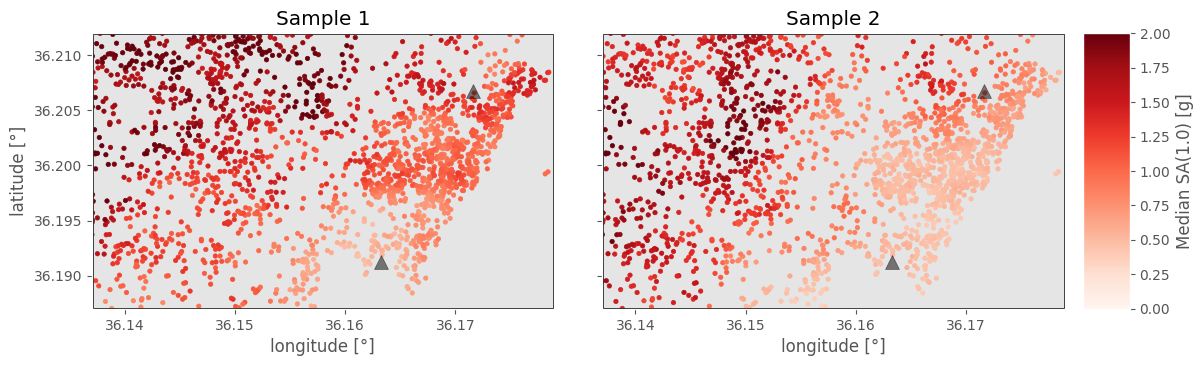

In [16]:
fig, axs = plt.subplots(1,2, figsize=(12,3.5), sharey=True, constrained_layout=True)
for i, ax in enumerate(axs):
    im = ax.scatter(dfsites_sim.longitude, dfsites_sim.latitude, c=np.exp(sim_logim2)[i,:], vmin=0, vmax=2, 
                    s=10, cmap=plt.get_cmap('Reds'))
    ax.set_aspect('equal')
    for surf in rupture_surface.surfaces:
        lons, lats = surf.get_surface_boundaries()
        ax.plot(lons, lats, color='black', lw=2,zorder=2, label=label)
    ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=100, color='black', alpha=0.5, edgecolor='black')
    ax.plot(lons_bbox, lats_bbox, color='black', lw=2)
    ax.set_xlim([lons_bbox.min(), lons_bbox.max()]); ax.set_ylim([lats_bbox.min(), lats_bbox.max()])
    ax.grid(False)
    if i==1: plt.colorbar(im, label='Median ' + im_string + ' [g]')
    if i==0: ax.set_ylabel('latitude [°]')
    ax.set_xlabel('longitude [°]'); 
    ax.set_xticks(np.arange(36.140, 36.180, 0.01))
    ax.set_title('Sample ' + str(i+1))
plt.show()

**Compute proportions of sites where a threshold amplitude was exceeded**

For the same 2000 building sites, we will now compute the probability distribution of the proportion of sites where the intensity measure exceeded a certain threshold. 
First, sample a large number of ground-motion fields (like the example in the figure above). Then, for each sample, count the number of sites where the threshold was exceeded and divide by the total number of sites. 

In [17]:
nsamples = 10000
threshold = 0.75 # unit g !
sim_logim2 = shakemap.sample_logIM(sites, nsamples=nsamples, conditional=True, seed=31)
prop_exceedance = np.sum((np.exp(sim_logim2) > threshold), axis=1) / len(dfsites_sim)

The histogram below indicates the number of samples associated to each proportion of sites, while we separately state the mean, as well as the 5% and 95% quantiles. The figure and the stated results indicate that the **remaining uncertainty in the ground-motion intensity measure** is still substantial: The results suggest a 90% confidence that the proportion of sites where the threshold was exceeded is **between 62.2 and 92.4%**. This is depsite the facts that the considered buildings are distributed over a very small area (4x3km) and that there are two seismic stations in this region plus an additional two stations very close to it. 

Note that these results are for one specific ground-motion model and one specific spatial correlation model. Feel free to re-run the code using the different implement models or implement your own models.

{'mean': 0.782, '5,95% quantiles': (0.622, 0.924)}


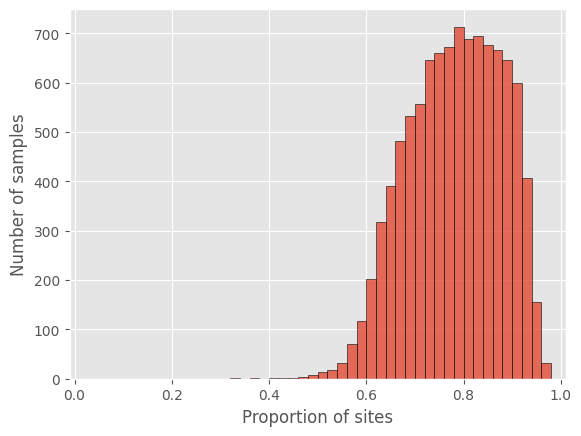

In [28]:
res_metrics = {'mean': np.round(np.mean(prop_exceedance),3), 
               '5,95% quantiles': tuple(np.round(np.quantile(prop_exceedance, [0.05, 0.95]),3))}
print(res_metrics)
fig, ax = plt.subplots()
bw = 0.02
bins = np.arange(0, 1+2*bw, bw)
ax.hist(prop_exceedance,bins,alpha=0.8, edgecolor='black')
ax.set_ylabel('Number of samples')
ax.set_xlabel('Proportion of sites')
ax.set_xlim([-0.01, 1.01])
plt.show()